In [23]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from Model import Model
from PlaceInputs import PlaceInputs2D
from utils import *
import configs

# Initialize RNN

In [24]:
# Parameters
arena_width_in_states = 10

In [51]:
num_states = arena_width_in_states**2
N_inp = N_bar = (arena_width_in_states*(arena_width_in_states+1))**2
place_inputs = PlaceInputs2D(N_inp, num_states).get_inputs()
arena_width_in_input_units = int(np.sqrt(N_inp))
model = Model(
    N_inp, N_bar, num_states, #plasticity_bias=-0.45,
    rec_strength=3,
    narrow_search_factor=0.5, wide_search_factor=1.,
    )

Place inputs generated from arena with width 10


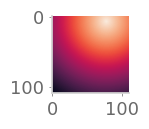

In [52]:
cache_states = [7]
for c in cache_states:
    plt.figure(figsize=(1,1))
    plt.imshow(place_inputs[c].reshape(arena_width_in_input_units, arena_width_in_input_units))
    plt.show()

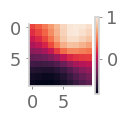

In [53]:
plt.figure(figsize=(1,1))
plt.imshow(np.corrcoef(place_inputs)[7].reshape((arena_width_in_states,arena_width_in_states)))
plt.colorbar()
plt.show()

In [ ]:
plt.imshow(np.corrcoef(place_inputs)[7].reshape((arena_width_in_states,arena_width_in_states)))

# Learning without skew

In [54]:
identification_s = 0.2

Now I just cached at location: 7


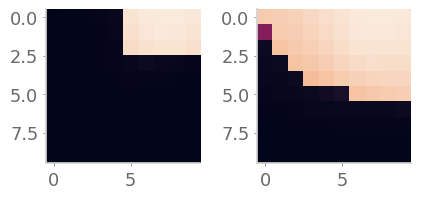

In [55]:
cache_identification = []
narrow_recall = []
wide_recall = []

model.reset()
for c_idx, cache_state in enumerate(cache_states):
    
    print("Now I just cached at location:", cache_state)
    preacts, acts, _, acts_over_time = model.run_recurrent(place_inputs)
    model.update(place_inputs[cache_state], acts[cache_state], preacts[cache_state])

    _, _, _cache_identification, _ = model.run_recall(identification_s, place_inputs)
    _cache_identification[np.isnan(_cache_identification)] = 0
    identification_readout = np.linalg.norm(_cache_identification, axis=1)
    identification_readout /= identification_readout.max()
    
    _, _, _wide_recall, _ = model.run_wide_recall(place_inputs)
    _wide_recall[np.isnan(_wide_recall)] = 0
    wide_readout = np.linalg.norm(_wide_recall, axis=1)
    wide_readout /= wide_readout.max()

    fig, axs = plt.subplots(1, 2, figsize=(5, 2))
    axs[0].imshow(identification_readout.reshape(arena_width_in_states, arena_width_in_states))
    axs[1].imshow(wide_readout.reshape(arena_width_in_states, arena_width_in_states))
    plt.show()

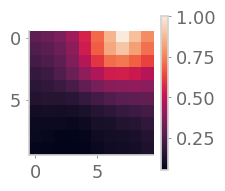

In [56]:
plt.figure(figsize=(2,2))
plt.imshow(np.corrcoef(acts)[7].reshape((arena_width_in_states,arena_width_in_states)))
plt.colorbar()
plt.show()

In [57]:
model.reset()

# Add predictive skew to RNN weights

In [58]:
old_J = model.J_xx.copy()

In [59]:
# Define T matrix in state space
T = np.eye(N_inp)

# Add non-stay transitions
cache_states_in_input_units = [
    int((c/num_states)*N_inp) for c in cache_states
    ]
for a in range(N_inp): # From
    a_x = a // arena_width_in_input_units; a_y = a % arena_width_in_input_units;
    for b in cache_states_in_input_units: #range(N_inp): # To
        b_x = b // arena_width_in_input_units; b_y = b % arena_width_in_input_units;
        dist = distance2D(a, b, arena_width_in_input_units)
        if 1 <= dist < 2:
            T[a,b] = 0.5
        if (b in cache_states_in_input_units) and (abs(a_y-b_y)<2):
            xdist = a_x - b_x
            if 0 < xdist < 50:
                T[a, b] = 0.4

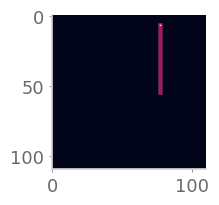

In [60]:
plt.figure(figsize=(2,2))
plt.imshow(
    T[:,cache_states_in_input_units[0]].reshape(
        (arena_width_in_input_units, arena_width_in_input_units)))
plt.show()

In [61]:
model.J_xx = old_J.copy()

In [62]:
model.J_xx += T

# RNN activity under different recurrent strengths
(Black line indicates the identity line)

#### $r=0$

In [63]:
_, acts0, _, _ = model.run_recurrent_r(place_inputs, 0.)

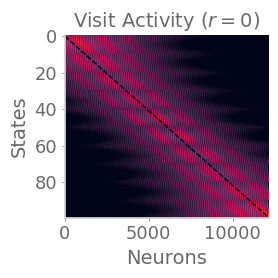

In [64]:
plt.figure(figsize=(3,3))
plt.imshow(acts0, aspect='auto')
plt.plot([0,N_bar-1], [0,num_states-1], color='black', linestyle='--')
plt.xlabel('Neurons')
plt.ylabel('States')
plt.title(f"Visit Activity ($r=0$)")
plt.tight_layout()
plt.show()

#### $r=0.3$

In [65]:
_, acts03, _, _ = model.run_recurrent_r(place_inputs, 0.3)

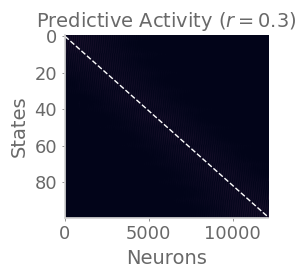

In [66]:
plt.figure(figsize=(3,3))
plt.imshow(acts03, aspect='auto')
plt.plot([0,N_bar-1], [0,num_states-1], color='white', linestyle='--')
plt.xlabel('Neurons')
plt.ylabel('States')
plt.title(f"Predictive Activity ($r=0.3$)")
plt.tight_layout()
plt.show()

#### $r=1.0$

In [19]:
_, acts1, _, _ = model.run_recurrent_r(place_inputs, 1.0)

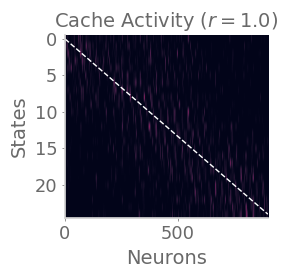

In [20]:
plt.figure(figsize=(3,3))
plt.imshow(acts1, aspect='auto')
plt.plot([0,N_bar-1], [0,num_states-1], color='white', linestyle='--')
plt.xlabel('Neurons')
plt.ylabel('States')
plt.title(f"Cache Activity ($r=1.0$)")
plt.tight_layout()
plt.show()

# Learning with skew

Now I just cached at location: 7


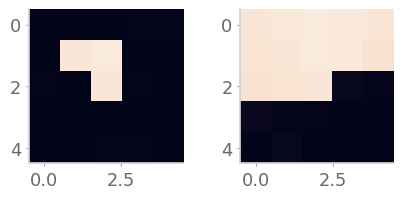

In [21]:
cache_identification = []
narrow_recall = []
wide_recall = []

for c_idx, cache_state in enumerate(cache_states):
    
    print("Now I just cached at location:", cache_state)
    preacts, acts, _, acts_over_time = model.run_recurrent(place_inputs)
    model.update(place_inputs[cache_state], acts[cache_state], preacts[cache_state])

    _, _, _cache_identification, _ = model.run_recall(identification_s, place_inputs)
    _cache_identification[np.isnan(_cache_identification)] = 0
    identification_readout = np.linalg.norm(_cache_identification, axis=1)
    identification_readout /= identification_readout.max()
    
    _, _, _wide_recall, _ = model.run_wide_recall(place_inputs)
    _wide_recall[np.isnan(_wide_recall)] = 0
    wide_readout = np.linalg.norm(_wide_recall, axis=1)
    wide_readout /= wide_readout.max()

    fig, axs = plt.subplots(1, 2, figsize=(5, 2))
    axs[0].imshow(identification_readout.reshape(arena_width_in_states, arena_width_in_states))
    axs[1].imshow(wide_readout.reshape(arena_width_in_states, arena_width_in_states))
    plt.show()

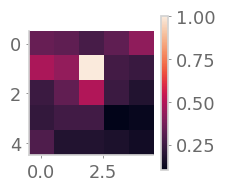

In [22]:
plt.figure(figsize=(2,2))
plt.imshow(np.corrcoef(acts)[7].reshape((arena_width_in_states,arena_width_in_states)))
plt.colorbar()
plt.show()